In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from scipy.spatial import cKDTree as KDTree
from tqdm.notebook import tqdm

In [2]:
prod = '/home/aalvarez/Work/Data/SC8/PHZPRD_D3_3_NOMINAL_20211006T095754-37VOZ8CE-20211006-095828-003'

In [3]:
ref = Table.read(os.path.join(prod, 'ProductionInputEcdmHandler/star_reference_sample_dir.dir/phot.fits'), hdu=1)
len(ref)

500000

In [4]:
target = Table.read(os.path.join(prod, 'GalaxyFilteringTask/star_catalog.fits'))
len(target)

1691

In [5]:
truth = Table.read(os.path.join(prod, 'NnpzStarSed/output_file.fits'))

In [6]:
config = dict()
exec(open('/home/aalvarez/Work/Data/SC8/PHZPRD_D3_3_NOMINAL_20211006T095754-37VOZ8CE-20211006-095828-003/data/nnpz_star_sed_07Jun2021-094516.conf').read(), config)

In [31]:
# Missing bands!
ref_filters = config['reference_sample_phot_filters']
target_filters = config['target_catalog_filters']

In [32]:
ref_selected = []
target_selected = []
for rname, (tname, terr) in zip(ref_filters, target_filters):
    if np.isnan(target[tname]).sum() < 1:
        ref_selected.append(rname)
        target_selected.append((tname, terr))
print(len(ref_selected), ref_selected)

9 ['euclid/VIS', 'euclid/Y', 'euclid/J', 'euclid/H', 'subaru/z', 'megacam/u', 'megacam/r', 'jpcam/g', 'panstarrs/i']


In [9]:
vis = ref_selected.index('euclid/VIS')

# Normalize the reference sample

In [10]:
ref_photo = np.zeros((len(ref), len(ref_selected)))
for i, fname in enumerate(ref_selected):
    ref_photo[:, i] = ref[fname]

In [11]:
ref_l2norm = ref_photo / np.sqrt(np.sum(ref_photo**2, axis=1, keepdims=True))

# KDTree

In [12]:
kdtree = KDTree(ref_l2norm)

# Load and normalize the target

In [13]:
target_photo = np.zeros((len(target), len(target_selected)))
for i, (fname, ferr) in enumerate(target_selected):
    target_photo[:, i] = target[fname]

In [14]:
target_l2norm = target_photo / np.sqrt(np.sum(target_photo**2, axis=1, keepdims=True))

In [15]:
target_mask = np.isnan(target_photo).sum(axis=1) == 0
target_mask = target_mask & (truth['FLAGS_1'] == 0)
target_mask.sum() / len(target)

0.7001774098166765

In [16]:
masked_norm = target_l2norm[target_mask]
masked_truth = truth[target_mask]

In [17]:
(target[target_mask]['OBJECT_ID'] == masked_truth['OBJECT_ID']).all()

True

# How many match?

In [18]:
def get_matches(ref_ids):
    matches = np.zeros(len(masked_truth))
    best = np.zeros(len(masked_truth))
    best_ids = np.flip(masked_truth['NEIGHBOR_WEIGHTS'].argsort(axis=1), axis=1)

    for i in range(len(masked_truth)):
        match = np.in1d(masked_truth['NEIGHBOR_IDS'][i][best_ids[i]], ref_ids[i])
        if match.any():
            matches[i] = match.argmax() + 1
        else:
            matches[i] = -1
    return matches

  0%|          | 0/8 [00:00<?, ?it/s]

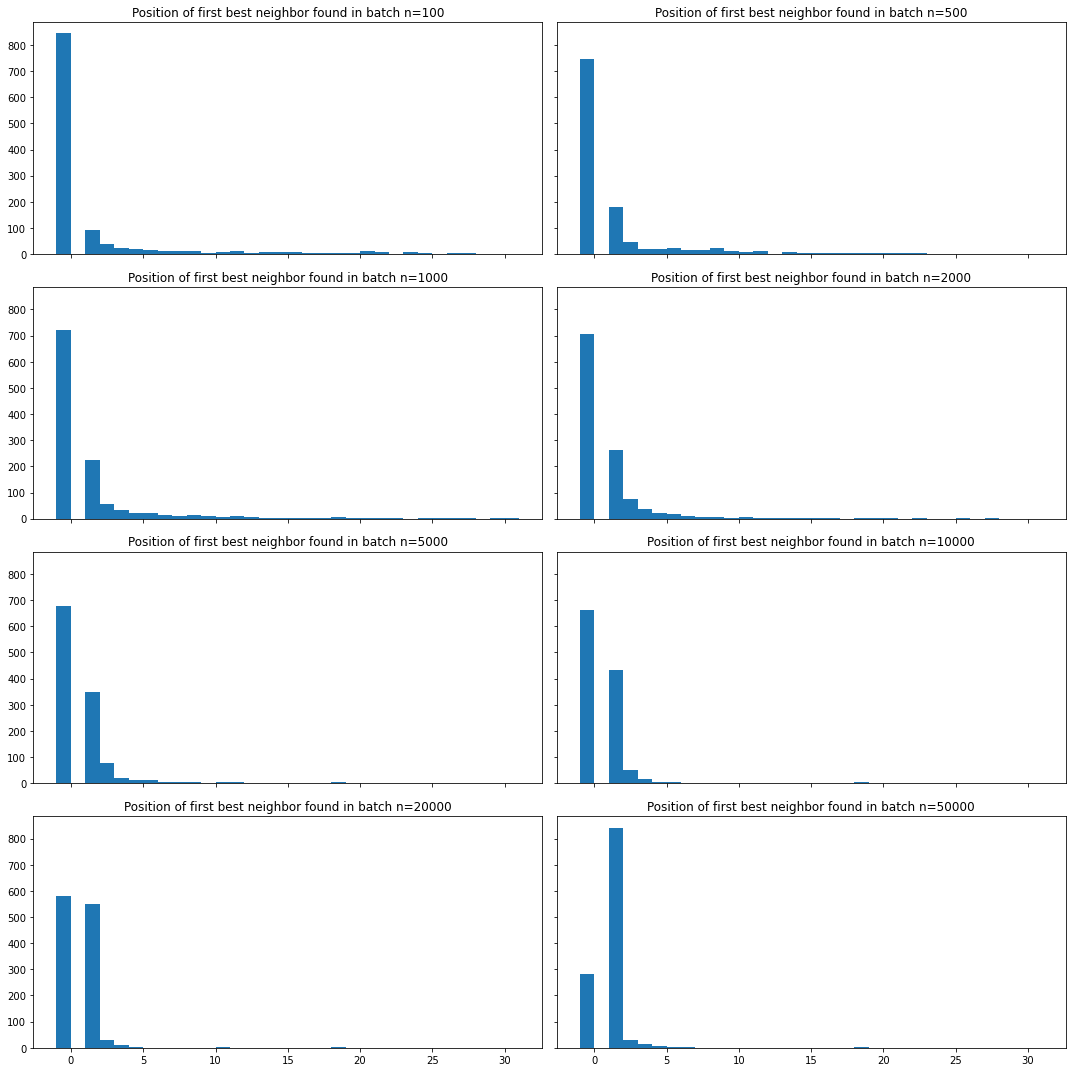

In [19]:
batches = np.asarray([100, 500, 1000, 2000, 5000, 10000, 20000, 50000])

fig, axes = plt.subplots(ncols=2, nrows=4, figsize=(15, 15), sharex=True, sharey=True)

for i, ax in enumerate(tqdm(axes.ravel())):
    k = batches[i]
    _, ref_idx = kdtree.query(masked_norm, k=k)
    ref_ids = ref['ID'][ref_idx]
    matches = get_matches(ref_ids)
        
    ax.hist(matches, bins=np.arange(-1, 32))
    ax.set_title(f'Position of first best neighbor found in batch n={k}')
plt.tight_layout()
plt.savefig('/home/aalvarez/Downloads/batch_star.png')
plt.show()

In [23]:
(masked_norm < 0).sum()

477